# This tutorial is running on Geforce GTX 1080Ti 12GB

## Load Basic Library

In [1]:
import math
import numpy as np
import tensorflow as tf

## Set Environment and Parameters

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use first GPU

seed = 2 # random seed
model_dir = "model_DCGAN/" # folder for saving model and log
BATCH_SIZE = 1024 # number of images in one batch
NOISE_DIM = 100 # noise dimension for generator
EPOCHS = 20
SAVE_SUMMARY_STEPS = 50 # save summary to tensorboard - one step means one batch
NUM_GPUS = 1 # number of GPU

## Load Data
Use MNIST dataset

In [3]:
(image, label),(_, _)  = tf.keras.datasets.mnist.load_data()
image = np.expand_dims(image, axis=-1)
label = np.expand_dims(label, axis=-1)
print("Image shape:", image.shape)
print("Label shape:", label.shape)

Image shape: (60000, 28, 28, 1)
Label shape: (60000, 1)


## Feed Training Data to Model

In [4]:
def train_input_fn(images, labels):
    
    def make_generator(images, labels):

        def _generator():
            for image, label in zip(images, labels):
                yield image, label

        return _generator
    
    # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
    def _preprocessing(image, label):
        image = image * (2.0 / 255.0) - 1.0
        return image, label
    
    dataset = tf.data.Dataset.from_generator(make_generator(images, labels), (tf.float32, tf.int64))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat(EPOCHS)
    dataset = dataset.map(_preprocessing)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(None)
    
    iterator = dataset.make_one_shot_iterator()
    
    images, labels = iterator.get_next()
    images = tf.reshape(images, [-1, 28, 28, 1])
    print("output image:", images.shape)
    
    tf.summary.image("images", images)
    
    random_noises = tf.random_normal(shape=(BATCH_SIZE, NOISE_DIM))
    
    features = {"images" : images,
                "random_noises" : random_noises}
    
    return features, labels

## Feed Random Noise Data to Model for Eval and Prediction

In [5]:
def random_noise_input_fn():
    
    np.random.seed(seed)
    
    dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.randn(16, NOISE_DIM), dtype=tf.float32))
    
    iterator = dataset.make_one_shot_iterator()
    
    noise = iterator.get_next()
    
    return {"random_noises" : noise}, None

## Model Structure
**Remember: Do batch normalization in training mode, but not in evaluation and prediction mode**  
This model Structure based on DCGAN

In [6]:
def generator(vectors, training):
    
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("block1"):
            vectors = tf.layers.dense(vectors, units=1024, name="dense")
            vectors = tf.layers.batch_normalization(vectors, training=training, name="batch_normalization")
            vectors = tf.nn.leaky_relu(vectors, alpha=0.2, name="leaky_relu")
        with tf.variable_scope("block2"):
            vectors = tf.layers.dense(vectors, units=7*7*128, name="dense")
            vectors = tf.layers.batch_normalization(vectors, training=training, name="batch_normalization")
            vectors = tf.nn.leaky_relu(vectors, alpha=0.2, name="leaky_relu")
        images = tf.reshape(vectors, [-1, 7, 7, 128])
        with tf.variable_scope("block3"):
            images = tf.layers.conv2d_transpose(images, filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", name="deconv")
            images = tf.layers.batch_normalization(images, training=training, name="batch_normalization")
            images = tf.nn.leaky_relu(images, alpha=0.2, name="leaky_relu")
        with tf.variable_scope("output"):
            images = tf.layers.conv2d_transpose(images, filters=1, kernel_size=(4, 4), strides=(2, 2), padding="same", name="deconv")
            images = tf.nn.tanh(images, name="tanh")
            
        return images
    
def discriminator(images, training):
    
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("block1"):
            images = tf.layers.conv2d(images, filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", name="conv")
            images = tf.layers.batch_normalization(images, training=training, name="batch_normalization")
            images = tf.nn.leaky_relu(images, alpha=0.2, name="leaky_relu")
        with tf.variable_scope("block2"):
            images = tf.layers.conv2d(images, filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same", name="conv")
            images = tf.layers.batch_normalization(images, training=training, name="batch_normalization")
            images = tf.nn.leaky_relu(images, alpha=0.2, name="leaky_relu")
        vectors = tf.layers.flatten(images, name="flatten")
        with tf.variable_scope("block3"):
            vectors = tf.layers.dense(vectors, units=1024, name="dense")
            vectors = tf.layers.batch_normalization(vectors, training=training, name="batch_normalization")
            vectors = tf.nn.leaky_relu(vectors, alpha=0.2, name="leaky_relu")
        with tf.variable_scope("output"):
            values = tf.layers.dense(vectors, units=1, name="dense")
    return values

## Model Function for tf.Estimator
To save model for tensorflow serving, set **`export_outputs`** parameter in prediction mode

In [7]:
def model_fn(features, labels, mode):
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        training = True
    else:
        training = False
    
    fake_images = generator(features["random_noises"], training)
    fake_values = discriminator(fake_images, training)
    
    # Prediction mode for tensorflow serving
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            "images": fake_images,
            "fake_values": fake_values
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, export_outputs={ 
            'output': tf.estimator.export.PredictOutput(predictions)})
    
    # calculate cross entropy loss   
    discriminator_fake_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(fake_values), logits=fake_values, scope="discriminator_fake_loss")
    generator_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(fake_values), logits=fake_values, scope="generator_loss")
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        
        real_images = features["images"]
        real_values = discriminator(real_images, training)
        
        discriminator_real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_values), logits=real_values, scope="discriminator_real_loss")
        discriminator_loss = tf.add(discriminator_real_loss, discriminator_fake_loss, name="discriminator_loss")
        tf.summary.scalar("discriminator_loss", discriminator_loss)
        
        generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
        
        # for batch normalization, tell tensorflow update batch normalization mean and variance
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            discriminator_train_op = discriminator_optimizer.minimize(discriminator_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator"))
            generator_train_op = generator_optimizer.minimize(generator_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator"))
        
        step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
        train_op = tf.group([discriminator_train_op, generator_train_op, step])
        
        # monitor trianing information
        logging_hook = tf.train.LoggingTensorHook({"generator_loss" : generator_loss,
                                                   "discriminator_loss" : discriminator_loss}, 
                                                  every_n_iter=SAVE_SUMMARY_STEPS)
        
        return tf.estimator.EstimatorSpec(mode, loss=generator_loss, train_op=train_op, training_hooks=[logging_hook])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        tf.summary.image("fake_images", fake_images, max_outputs=12)
        eval_summary_hook = tf.train.SummarySaverHook(
                                save_steps=1,
                                output_dir=model_dir + "/eval_summary",
                                summary_op=tf.summary.merge_all())
        metrics = {"discriminator_fake_loss" : tf.metrics.mean(discriminator_fake_loss)}
        return tf.estimator.EstimatorSpec(mode, loss=generator_loss, eval_metric_ops=metrics, evaluation_hooks=[eval_summary_hook])

## For Multiple GPU (Parallel Computing)
Testing, not stable version  
Evaluation is not yet distributed

In [8]:
def get_distribution_strategy(num_gpus, all_reduce_alg=None):
    """Return a DistributionStrategy for running the model.
    Args:
    num_gpus: Number of GPUs to run this model.
    all_reduce_alg: Specify which algorithm to use when performing all-reduce.
      See tf.contrib.distribute.AllReduceCrossTowerOps for available algorithms.
      If None, DistributionStrategy will choose based on device topology.
    Returns:
    tf.contrib.distribute.DistibutionStrategy object.
    """
    if num_gpus == 0:
        return tf.contrib.distribute.OneDeviceStrategy("device:CPU:0")
    elif num_gpus == 1:
        return tf.contrib.distribute.OneDeviceStrategy("device:GPU:0")
    else:
        if all_reduce_alg:
            return tf.contrib.distribute.MirroredStrategy(
                num_gpus=num_gpus,
                cross_tower_ops=tf.contrib.distribute.AllReduceCrossTowerOps(
                    all_reduce_alg, num_packs=num_gpus))
        else:
            return tf.contrib.distribute.MirroredStrategy(num_gpus=num_gpus)

## Set Runing Config

In [9]:
session_config = tf.ConfigProto()
session_config.gpu_options.per_process_gpu_memory_fraction = 0.8
session_config.gpu_options.allow_growth = True
config = tf.estimator.RunConfig(model_dir=model_dir, 
                                tf_random_seed=seed, 
                                save_summary_steps=SAVE_SUMMARY_STEPS, 
                                save_checkpoints_steps=SAVE_SUMMARY_STEPS, 
                                session_config=session_config,
                                keep_checkpoint_max=5, 
                                log_step_count_steps=SAVE_SUMMARY_STEPS, )
#                                train_distribute=get_distribution_strategy(NUM_GPUS)) #for mutiple GPUs
clf = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_dir, config=config)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model_DCGAN_test/', '_task_type': 'worker', '_num_worker_replicas': 1, '_task_id': 0, '_train_distribute': None, '_master': '', '_save_checkpoints_secs': None, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_log_step_count_steps': 50, '_device_fn': None, '_tf_random_seed': 2, '_service': None, '_save_summary_steps': 50, '_is_chief': True, '_keep_checkpoint_max': 5, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f492c9d12e8>, '_evaluation_master': '', '_save_checkpoints_steps': 50}


## Train and Evaluate

In [10]:
train_spec = tf.estimator.TrainSpec(lambda:train_input_fn(image, label), max_steps=1500)
eval_spec = tf.estimator.EvalSpec(lambda:random_noise_input_fn(), throttle_secs=1)
tf.estimator.train_and_evaluate(clf, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 50 or save_checkpoints_secs None.
output image: (?, 28, 28, 1)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into model_DCGAN_test/model.ckpt.
INFO:tensorflow:loss = 0.81121224, step = 0
INFO:tensorflow:discriminator_loss = 1.5764568, generator_loss = 0.81121224
INFO:tensorflow:Saving checkpoints for 50 into model_DCGAN_test/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-20-00:56:03
INFO:tensorflow:Graph was finalized.
I

({'discriminator_fake_loss': 0.44737142,
  'global_step': 1172,
  'loss': 1.3163781},
 [])

## Save model for Tensorflow Serving
Can not save model after **predict**, because `Graph` is finalized and cannot be modified  
You can assign which model to be saved by `checkpoint_path` parameter

In [11]:
# input
vector = tf.placeholder(tf.float32, shape=[None, NOISE_DIM], name='random_noises')
# input receiver
input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
    'random_noises': vector,
})

clf.export_savedmodel("saved_model/", input_fn, checkpoint_path="model_DCGAN/model.ckpt-1172")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['output', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Restoring parameters from model_DCGAN/model.ckpt-1172
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: saved_model/temp-b'1537405877'/saved_model.pb


b'saved_model/1537405877'

## Load model and predict
Estimator predict method return **generator** type, so if you want to get all predictions please use for loop  
```python
for result in results:
    print(result)
```

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_DCGAN/model.ckpt-1172
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


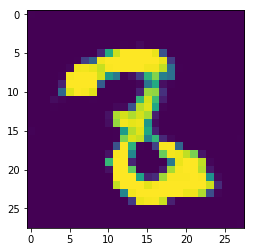

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
results = clf.predict(lambda: random_noise_input_fn(), checkpoint_path="model_DCGAN/model.ckpt-1172")
for result in results:
    plt.imshow(result["images"][:,:,0])
    break

## Load model from `Estimator.export_savedmodel`
Reference: https://qiita.com/parkkiung123/items/13adb482860f356f97f3  

INFO:tensorflow:Restoring parameters from saved_model/1537405877/variables/variables
(1, 28, 28, 1)


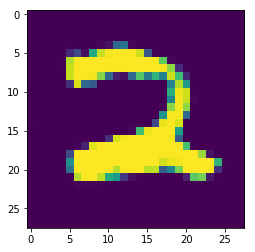

In [15]:
import tensorflow as tf
import numpy as np

export_dir = 'saved_model/1537405877'

with tf.Session(graph=tf.Graph()) as sess:
    # saved_model load
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)
    # print all tensor name
#     for op in sess.graph.get_operations():
#         print(op.values())
    # input
    i = sess.graph.get_tensor_by_name("random_noises:0")
    # output
    r = sess.graph.get_tensor_by_name("generator/output/tanh:0")
    image = sess.run(r, feed_dict={i:np.random.randn(1, NOISE_DIM)})
    print(image.shape)
    plt.imshow(image[0][:,:,0])